In [1]:
import numpy as np
import torch
import sklearn

# visualization
import seaborn
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner

%load_ext autoreload
%autoreload 2

In [2]:
import lbi.models
from lbi.nde import NeuralRatioEstimator, NeuralLikelihoodEstimator
from lbi.sequential import Sequential

In [3]:
import dataset
import sklearn.preprocessing

N = 500000

scaler = sklearn.preprocessing.StandardScaler().fit(dataset.obs)

param_dim = dataset.params.shape[-1]
obs_dim = dataset.obs.shape[-1]
observation = torch.tensor([[0.12, 125.]])

/media/jt/data/Projects/MSSM/datasets/Hollingsworth/read_dataset.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['chg2'][np.where(np.isnan(f['chg2']))[0]]=-1


In [4]:
# Make multivariate uniform prior distribution
priors = torch.distributions.Independent(torch.distributions.Uniform(low=torch.zeros(param_dim), 
                                                                     high=torch.ones(param_dim)), 
                                         reinterpreted_batch_ndims=1)

In [5]:
model = lbi.models.ConditionalFlow(dim=obs_dim, 
                                   context_dim=param_dim, 
                                   transform_type='autoregressive', 
                                   n_layers=1, 
                                   hidden_units=128,
                                   n_blocks=2, 
                                   dropout=0., 
                                   use_batch_norm=False, 
                                   tails='linear', 
                                   tail_bound=5, 
                                   n_bins=10,
                                   min_bin_height=1e-5, 
                                   min_bin_width=1e-5, 
                                   min_derivative=1e-5, 
                                   unconditional_transform=True,
                                   encoder=None)
optimizer = torch.optim.Adam(model.parameters())
nle = NeuralLikelihoodEstimator(model)

In [6]:
snle = Sequential(priors=priors, obs_data=observation, param_dim=param_dim, model=nle, optimizer=optimizer, 
                  simulator=None, 
                  n_rounds=1)

In [7]:
# Store data
print("Adding sims to sequential object")
snle.add_data(dataset.obs[:N], dataset.params[:N])

Adding sims to sequential object


In [8]:
global_step = 0
print("Training model")
global_step = snle.train(global_step=global_step)

Training model
Training on 425,000 samples. Validating on 75,000 samples.
Early stopped after 7 epochs


In [9]:
posterior_samples = snle.hmc(num_samples=200000, walker_steps=7500, burn_in=1500)

Sample: 100%|██████████| 9000/9000 [06:02, 24.81it/s, step size=6.30e-02, acc. prob=0.815]


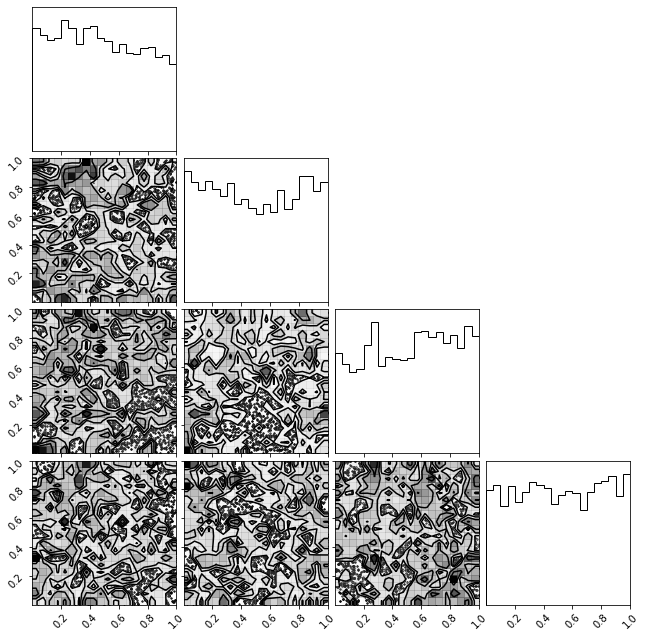

In [10]:
corner.corner(posterior_samples.numpy(), 
              range=[(0, 1) for i in range(param_dim)], 
             );